<a href="https://colab.research.google.com/github/adrj67/Topic_Modeling/blob/miprim/Mi6_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción
---
**Topic Modeling:** Busca descubrir qué tópicos discute un conjunto de documento. Es útil para hacer análisis rápidos y/o gruesos. No involucra entrenamietno complejo


---

En esta `notebook` se trabajará con una versión más reducida de un [dataset de tweets ](https://covid.dh.miami.edu/es/2020/09/22/acceso-a-nuestra-coleccion-de-twitter/) - [Twits Argentina año 2021](https://covid.dh.miami.edu/get/).

Se aplicarán los conceptos de TF-IDF, LSA y LDA para el análisis de los documentos en busca de los *tópicos principales* y la similitud entre documentos.

Esta notebook está construida en base a las siguientes notebooks también disponibles en Kaggle:
- [Notebook 1](https://www.kaggle.com/code/agmddenis/find-similar-articles-with-tf-idf)
- [Notebook 2](https://www.kaggle.com/code/patrickjellison/topic-modeling#Determine-the-Optimal-Topic-Number)
- [Notebook 3](https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim#%F0%9F%93%8A-pyLDAvis)

In [ ]:
# Importamos algunas librerías a utilizar
import pandas as pd
import string
import numpy as np
import nltk

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics.pairwise import linear_kernel
from matplotlib.ticker import MaxNLocator

from sklearn import metrics
from wordcloud import WordCloud
from matplotlib import pyplot as plt

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LsiModel
from gensim.corpora import Dictionary

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re

from pprint import pprint

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Importamos la libreria drive
from google.colab import drive
drive.mount("/content/drive") #Montamos el drive

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/db/dataset.txt')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547408 entries, 0 to 547407
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   contenido  547408 non-null  object
dtypes: object(1)
memory usage: 4.2+ MB


In [ ]:
# Previsualización de los datos
data.head(5)

,contenido
0,ok quiero llorar covid19 sal de mi
1,#video el laboratorio aleman biontech que desa...
2,este debe tener covid19 porque vuela de fiebre...
3,fue noticia covid19 todo lo que querias saber ...
4,primera vez que quiero que se termine el invie...


In [ ]:
# Elejimos para trabajar los primeros 10.000, antes eran 547407 twits
data = data.iloc[0:10000]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   contenido  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


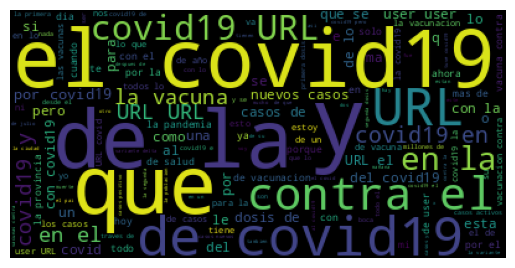

In [ ]:
# Generamos una nube de palabras
from wordcloud import WordCloud
wordcloud2 = WordCloud().generate(' '.join(data['contenido']))
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [ ]:
# Funcion para borrar palabras no necesarias (stopwords: de, la, el, etc.), URLs, @[menciones], #, etc
def clean_tweet(tweet):
    tweet = re.sub(r'URL', '', tweet)  # eliminar URLs
    tweet = re.sub(r'user', '', tweet)  # eliminar 'user'
    tweet = re.sub(r'url', '', tweet)  # eliminar URLs
    tweet = re.sub(r'covid19', '', tweet)  # eliminar URLs
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)  # eliminar menciones
    tweet = re.sub(r'#', '', tweet)  # eliminar hashtags
    #tweet = re.sub(r'[^A-Za-z0-9 ]+', '', tweet)  # eliminar caracteres especiales
    tweet = tweet.lower()  # convertir a minúsculas
    # Eliminar stopwords
    words = [w for w in word_tokenize(tweet) if not w in stopwords.words('spanish')]
    tweet = ' '.join(words)
    return tweet

In [ ]:
# Limpieza del dataframe
# Stopwords y lemmas
import re
data['contenido'] = data['contenido'].apply(lambda x: clean_tweet(x))

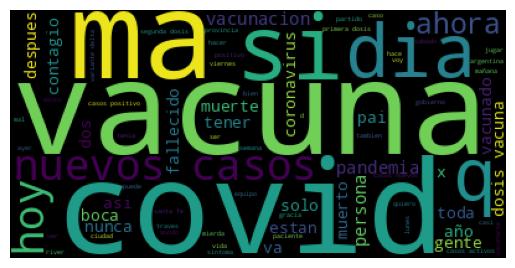

In [ ]:
# Generamos otra nube de palabras
from wordcloud import WordCloud
wordcloud2 = WordCloud().generate(' '.join(data['contenido']))
# Generate plot
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

# **TF - IDF:** Topic Frequency - Inverse Document Frequency


---


Técnica que busca cuantificar la importancia de términos dentro de un conjunto de documentos. Funciona a nivel de palabras, por lo que no es Topic Modeling propiamente dicho.


Para comenzar a usar Tfidf, primero se debe crear un [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) para contar la cantidad de palabras (frecuencia de términos):

In [ ]:
#Inicializar CountVectorizer()
cv=CountVectorizer()

# Este paso genera recuentos de palabras para las palabras de los documentos.
word_count_vector=cv.fit_transform(data['contenido'])

In [ ]:
# (Número de documentos, Número de términos únicos)
word_count_vector.shape

(10000, 18545)

Ahora tenemos que computar los valores **IDF**:

In [ ]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [ ]:
# Podemos mostrar algunos valores IDF en orden descendente
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(),columns=["idf_weights"])

# sort ascending
df_idf.sort_values(by=['idf_weights'])

,idf_weights
casos,3.074753
covid,3.233159
mas,3.252943
vacuna,3.287796
si,3.561456
...,...
informarles,9.517293
informarnos,9.517293
ascendente,9.517293
ascensor,9.517293


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Una vez que tenemos los valores IDF, ahora podemos calcular las puntuaciones tf-idf para cualquier documento o conjunto de documentos. Al invocar `tfidf_transformer.transform(count_vector)` finalmente se calculan las puntuaciones tf-idf para los documentos. Internamente, esto es calcular la multiplicación tf * idf donde la frecuencia de los términos se pondera por sus valores IDF.

In [ ]:
# count matrix
count_vector=cv.transform(data['contenido'])

# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)

Ahora, imprimamos los valores tf-idf del documento de la posición 50 para ver si tiene sentido:

In [ ]:
feature_names = cv.get_feature_names_out()

#get tfidf vector for first document
first_document_vector=tf_idf_vector[100]

#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
ir,0.597455
restaurante,0.484737
pasaportecovid,0.469433
vas,0.352543
tener,0.251841
...,...
desgobierno,0.000000
desgaste,0.000000
desgarrador,0.000000
desfile,0.000000


In [ ]:
data.iloc[100]['contenido']

'ir restaurante vas tener ir pasaportecovid'

Una manera más directa de construir **TF-IDF**: [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf calculation
text_content = data['contenido']
vector = TfidfVectorizer(#max_df=0.3,         # drop words that occur in more than X percent of documents
                             #min_df=8,      # only use words that appear at least X times
                             #stop_words='spanish', # remove stop words
                             lowercase=True, # Convert everything to lower case
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

In [ ]:
feature_names = vector.get_feature_names_out()

#get tfidf vector for first document
first_document_vector=tfidf[100]

#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
ir,0.597455
restaurante,0.484737
pasaportecovid,0.469433
vas,0.352543
tener,0.251841
...,...
desgobierno,0.000000
desgaste,0.000000
desgarrador,0.000000
desfile,0.000000


Buscar documentos similares con TF-IDF:

In [ ]:
# Algunas funciones útiles

# Función para buscar los n documentos principales a partir de un string
def search(tfidf_matrix,model,request, top_n = 5):
    request_transform = model.transform([request])
    similarity = np.dot(request_transform,np.transpose(tfidf_matrix))
    x = np.array(similarity.toarray()[0])
    indices=np.argsort(x)[-top_n:][::-1]
    return indices

# Buscar documentos similares: obtener los primeros top_n documentos similares a un documento
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

# Mostrar resultados
def print_result(request_content,indices,X):
    print('\nsearch : ' + request_content)
    print('\nMejores resultados :')
    for i in indices:
        print('id = {0:5d} - title = {1}'.format(i,X['contenido'].loc[i]))

Buscar los primeros top_n documentos similares a una cadena de entrada

In [ ]:
request = 'Todas las actividades sociales'
#request = 'Los partidos de fútbol se suspenden con la pandemia'

result = search(tfidf,vector, request, top_n = 2)
print_result(request,result, data)


search : Todas las actividades sociales

Mejores resultados :
id =  7337 - title = consonancia flexibilizacion varias actividades dispuesta nacion raiz pandemia gobierno provincial dio conocer nuevas medidas respecta reuniones sociales actividades gastronomicas culturales cultos deportes entrerios
id =  5777 - title = gobierno provincial dio conocer nuevas medidas respecta reuniones sociales actividades gastronomicas culturales cultos deportes


Buscar documentos similares a un documento

In [ ]:
index = 5184
result = find_similar(tfidf, index, top_n = 3)
print_result('5184',result,data)


search : 5184

Mejores resultados :
id =  5294 - title = oficial : white_check_mark : tras detectar dos casos positivos @ decidio suspender tres proximos amistosos budapest honved 2407 dinamo kiev 2607 hertha berlin 2807 equipo buscara dos rivales zona enfrentar
id =  4174 - title = lee comunicado completo
id =  7215 - title = operativos vacunacion proximos dias


# LSA: Análisis Latente Semántico (LSA)


---

Para poder aplicar este modelo, debemos formatear nuestros documentos en una matriz de términos-documentos. Para esto, primero se limpiarán los datos para tener todo el texto en minúscula, eliminar stopwords y lematización de los términos

Primero creamos un diccionario con los pares `id: content` de cada documento:

In [ ]:
# Función para crear un diccionario:
def CorpusDictionary(df):
    corpus_dictionary = dict(zip(df.index, df.contenido))
    return corpus_dictionary

corpus_dictionary = CorpusDictionary(data)

A continuación, normalizamos el texto haciendo lo siguiente:

- Eliminar caracteres no-ASCII
- Convertir todo el texto a minúsucla
- Tokenizar el texto
- Eliminar stopwords
- Lematización de los términos

In [ ]:
# Función para normalizar el texto
lemmatizer = WordNetLemmatizer()
def CorpusNormalizer(rawCorpus):
    corpus_temp = rawCorpus
    for key, value in corpus_temp.items():

        text = value

        # Texto en minúscula
        text = text.lower()

        # Eliminar caracteres non-ASCII
        text = re.sub(r'[^\x00-\x7f]',r' ', text)

        # Eliminar signos de puntuación
        text = re.sub(r'[^\w\s]', '', text)

        # Eliminar stopwords
        words = [w for w in word_tokenize(text) if not w in stopwords.words('spanish')]
        text = ' '.join(words)

        #words = [lemmatizer.lemmatize(w) for w in word_tokenize(text)]
        #text = ' '.join(words)

        corpus_temp[key] = text

    return corpus_temp

Vectorizar el texto:¶

- Tokenizar cada documento
- Crear una lista de tokens
- Crear el vector TDF

In [ ]:
def corpusVectorizer(normalizedCorpus):
    corpus_temp = normalizedCorpus

    # Initialize list of token_lists
    token_lists = []

    # Initialize list of tdf scores
    tdf_list = []

    # Create a token list
    for key, value in corpus_temp.items():

        # Tokenize the document
        token_list = nltk.word_tokenize(value)
        corpus_temp[key] = token_list

        # Add list of tokens to token_lists
        token_lists.append(token_list)

    # Create dictionary from the list of token_lists
    id2word = Dictionary(token_lists)

    # Create a vector of tdf
    for key, value in corpus_temp.items():

        # Calculate tdf based on dictionary
        tdf = id2word.doc2bow(value)
        corpus_temp[key] = tdf

        # Add tdf score to the tdf_list
        tdf_list.append(tdf)

    return corpus_temp, id2word, tdf_list

En este punto ya tenemos todo para poder aplicar LSA. Para esto, utilizaremos el modelo [LsiModel](https://radimrehurek.com/gensim/models/lsimodel.html) del módulo [gensim](https://radimrehurek.com/gensim/index.html):

In [ ]:
# Definimos el hiperparámetro que determina la cantidad de tópicos a generar, en este caso probamos con 15
k = 5

# Se crea el diccionario id, contenido del corpus de documentos
corpus_dictionary = CorpusDictionary(data)

# Se normaliza el corpus de documentos
corpus_normalized = CorpusNormalizer(corpus_dictionary)

# Se vectoriza el corpus, con esto generamos las siguientes estructuras:
# - corpus_vectorized: corpus vectorizado
# - id2word: Diccionario de términos para construir el modelo
# - tdf_list: Lista de puntuaciones TDF para construir el modelo
corpus_vectorized, id2word, tdf_list = corpusVectorizer(corpus_normalized)

lsi_model = LsiModel(corpus=tdf_list, num_topics=k, id2word=id2word)

In [ ]:
# Podemos mostrar los primero 5 tópicos encontrados
lsi_model.show_topics(num_topics=5)

[(0,
  '-0.704*"casos" + -0.295*"nuevos" + -0.224*"mas" + -0.165*"dosis" + -0.157*"covid" + -0.132*"vacuna" + -0.121*"coronavirus" + -0.121*"personas" + -0.117*"si" + -0.116*"altas"'),
 (1,
  '0.432*"casos" + -0.422*"dosis" + -0.380*"vacuna" + -0.337*"mas" + -0.227*"si" + 0.181*"nuevos" + -0.173*"covid" + -0.167*"vacunas" + -0.165*"vacunacion" + -0.154*"argentina"'),
 (2,
  '-0.439*"si" + -0.403*"mas" + 0.333*"covid" + 0.324*"argentina" + 0.277*"dosis" + 0.219*"coronavirus" + 0.191*"sputnik" + -0.170*"q" + 0.159*"cordoba" + 0.125*"mira"'),
 (3,
  '0.565*"si" + 0.471*"covid" + -0.409*"mas" + -0.275*"dosis" + 0.186*"q" + -0.119*"vacunacion" + 0.095*"argentina" + -0.090*"personas" + 0.086*"coronavirus" + 0.085*"boca"'),
 (4,
  '-0.597*"mas" + 0.558*"vacuna" + -0.341*"covid" + 0.237*"dosis" + -0.133*"argentina" + 0.118*"si" + 0.108*"vacunacion" + 0.107*"casos" + -0.082*"coronavirus" + 0.067*"primera"')]

# LDA: Asignación Latente de Dirichlet


---

Suposiciones:

- Los documentos con tópicos similares usan grupos similares de palabras.
- Los documentos son distribuciones de palabras sobre tópicos latentes.
- Los tópicos son distribuciones de probabilidad sobre palabras.

Este modelo se puede construir a partir de los mismos datos que usa LSA.
En este caso, el modelo LDA nos permite generar:

- El modelo propiamente dicho con los tópicos encontrados y,
- una mediad de coherencia de cada tópico encontrado

In [ ]:
# Función para crear un modelo LDA
def lda_Model(tdf_list, id2word, num_topics):

    # Crear el modelo LDA
    model = LdaModel(corpus=tdf_list,
                     id2word=id2word,
                     num_topics=num_topics,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     alpha='auto',
                     per_word_topics=True)

    cm = CoherenceModel(model = model, corpus=tdf_list, coherence='u_mass')
    coherence = cm.get_coherence()

    return model, coherence

Seguimos los mismos pasos que usamos para generar un modelo LSA:

In [ ]:
# Definimos el hiperparámetro que determina la cantidad de tópicos a generar, en este caso probamos con 15
k = 3 # 5 topicos

# Se crea el diccionario id, contenido del corpus de documentos
corpus_dictionary = CorpusDictionary(data)

# Se normaliza el corpus de documentos
corpus_normalized = CorpusNormalizer(corpus_dictionary)

# Se vectoriza el corpus, con esto generamos las siguientes estructuras:
# - corpus_vectorized: corpus vectorizado
# - id2word: Diccionario de términos para construir el modelo
# - tdf_list: Lista de puntuaciones TDF para construir el modelo
corpus_vectorized, id2word, tdf_list = corpusVectorizer(corpus_normalized)

# Generamos el modelo
model = lda_Model(tdf_list, id2word, k)[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Podemos mostrar los 15 tópicos encontrados
pprint(model.print_topics())

[(0,
  '0.033*"casos" + 0.013*"personas" + 0.013*"nuevos" + 0.010*"coronavirus" + '
  '0.010*"salud" + 0.009*"ciudad" + 0.008*"pacientes" + 0.008*"contagios" + '
  '0.008*"pandemia" + 0.007*"dos"'),
 (1,
  '0.028*"mas" + 0.013*"vacunas" + 0.009*"boca" + 0.008*"argentina" + '
  '0.008*"jugar" + 0.007*"si" + 0.006*"positivo" + 0.006*"river" + '
  '0.005*"dosis" + 0.005*"hace"'),
 (2,
  '0.028*"vacuna" + 0.015*"covid" + 0.015*"vacunacion" + 0.015*"si" + '
  '0.012*"dosis" + 0.010*"q" + 0.009*"18" + 0.007*"recibir" + 0.006*"tener" + '
  '0.006*"dias"')]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


A modo de previsualización de los términos que componen un tópico, podemos listar los términos y sus frecuencias por tópico:

In [ ]:
# Función para mostrar la distribución de términos-tópicos
def topicWordDistribution(model, k):

    print('\nDistribución Términos-Tópicos')
    print('------------------------')

    table = "{:<20} {:<22}"

    for topic in model.show_topics(formatted=False, num_topics = k):
        print('\nTópico:', topic[0])
        print('---------')
        print (table.format('Término', ' Frecuencia'))
        print (table.format('-------------------', '--------------------'))

        for word in topic[1]:
            print (table.format(word[0], word[1]))

topicWordDistribution(model, k)


Distribución Términos-Tópicos
------------------------

Tópico: 0
---------
Término               Frecuencia           
-------------------  --------------------  
casos                0.03336881101131439   
personas             0.01260186918079853   
nuevos               0.01253177784383297   
coronavirus          0.01030152291059494   
salud                0.00961296446621418   
ciudad               0.00904801208525896   
pacientes            0.008155714720487595  
contagios            0.007685685530304909  
pandemia             0.007528312969952822  
dos                  0.007231187075376511  

Tópico: 1
---------
Término               Frecuencia           
-------------------  --------------------  
mas                  0.02794109843671322   
vacunas              0.01292614545673132   
boca                 0.00899661798030138   
argentina            0.008384693413972855  
jugar                0.007641247473657131  
si                   0.006729072891175747  
positivo             0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


También podemos generar una bolsa de términos o nube de términos para visualizar los términos más frecuentes por tópico:

In [ ]:
# Función para mostrar la distribución de términos-tópicos con nubes de términos
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("on")
    plt.tick_params(left = False, bottom = False)
    plt.xticks([])
    plt.yticks([])
    plt.title("Topic" + " "+ str(topic))
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


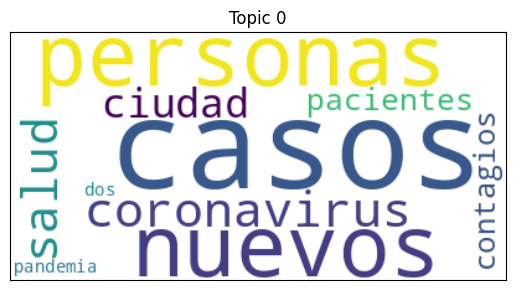

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


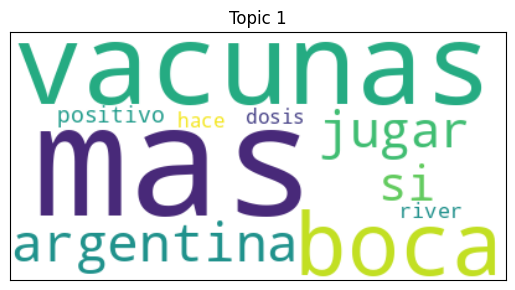

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


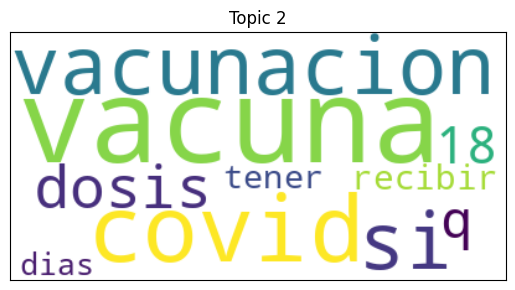

In [ ]:
# Mostrar las nubes de términos
for i in range(0, k):
    create_wordcloud(model, topic=i)

También podemos mostrar la distribución de los documentos y tópicos, es decir, a qué tópico pertenece cada documento:

In [ ]:
def documentTopicDF(k):

    # Creamos un dataframe
    df_dist = pd.DataFrame(columns=['id'])

    # Inicializar diccionario para almacenar nuevos valores
    row = {}

    # crear columnas para tópicos
    for i in range(k):
        topicName = 'Topic' + str(i)
        df_dist[topicName] = ''
        row[topicName] = 0

    for key, value in corpus_vectorized.items():

        # Obtener Tópicos
        topics = model[corpus_vectorized[key]][0]

        # Inicializar valores
        for i in range(k):
            topicName = 'Topic' + str(i)
            row[topicName] = 0.0

        # Agregar id al diccionario
        row['id'] = key

        # Agregar distribución de tópicos al diccionario
        for i in range(k):
            topicName = 'Topic' + str(i)
            for topic in topics:
                if topic[0] == i:
                    row[topicName] = round(float(topic[1]), 8)

        # Cree una fila de datos que contenga la identificación del documento y las distribuciones de tópicos.
        new_row = pd.Series(row)

        # Agregamos una fila de datos que almacena las distribuciones de tópicos y documentos
        df_dist = pd.concat([df_dist, new_row.to_frame().T], ignore_index=True)

    # Guardamos el id del documento como valor entero
    df_dist = df_dist.astype({"id": int})

    return df_dist

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Mostrar la distribución de tópicos y documentos
data_dist = documentTopicDF(k)

print('\nDistribución Tópicos-Documentos')
print('----------------------------\n')
data_dist.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Distribución Tópicos-Documentos
----------------------------



,id,Topic0,Topic1,Topic2
0,0,0.120430,0.293950,0.585620
1,1,0.125887,0.172182,0.701931
2,2,0.112938,0.154660,0.732402
3,3,0.273429,0.143675,0.582896
4,4,0.116947,0.611981,0.271072


In [ ]:
data.iloc[4]['contenido']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'primera vez quiero termine invierno porfa enferme 5 veces va año siempre pensando termino aislada'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


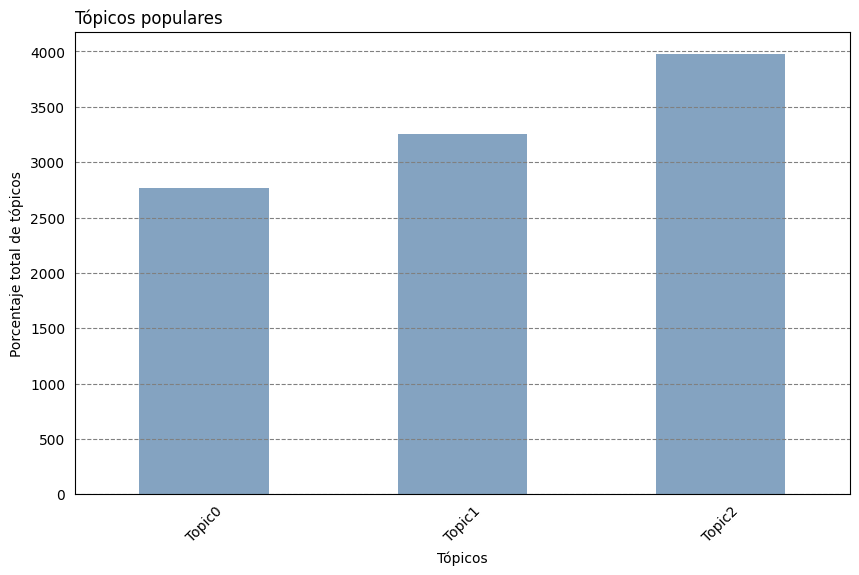

In [ ]:
# Gráfico de barras para comparar el porcentaje de tópicos

plt.figure(figsize=(10, 6))
plt.title("Tópicos populares", loc = 'left')
plt.xlabel("Tópicos")
plt.ylabel("Porcentaje total de tópicos")
plt.tick_params(bottom=False, left=False)
data_dist[data_dist.columns[1:6]].sum().plot.bar(rot=0, color=(0.2, 0.4, 0.6, 0.6))
plt.grid(axis='y', color='gray', linestyle='dashed')
plt.xticks(rotation=45)
plt.show()

# Visualización con pyLDAvis

[pyLDAvis](https://pypi.org/project/pyLDAvis/) es una biblioteca Python para visualización interactiva de modelos de tópicos.

pyLDAvis está diseñado para ayudar a los usuarios a interpretar los tópicos en un modelo de tópicos que se ha entrenado con un corpus de datos de texto. El paquete extrae información de un modelo de tópicos **LDA** ajustado para informar una visualización interactiva basada en web.

In [ ]:
# Instalamos pyLDAvis
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 25.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 

In [ ]:
# Instalamos la version de pandas que necesita pyLDAvis
!pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, tdf_list, id2word)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.125372  0.183791       1        1  37.940187
1     -0.118723 -0.187159       2        1  33.381509
0      0.244095  0.003368       3        1  28.678304, topic_info=            Term         Freq        Total Category  logprob  loglift
154        casos  1090.000000  1090.000000  Default  30.0000  30.0000
23        vacuna  1214.000000  1214.000000  Default  29.0000  29.0000
52           mas  1073.000000  1073.000000  Default  28.0000  28.0000
345   vacunacion   674.000000   674.000000  Default  27.0000  27.0000
435      vacunas   492.000000   492.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
522        julio    97.766030   102.127017   Topic3  -5.8110   1.2054
521          hoy   204.456088   412.674073   Topic3  -5.0732   0.5467
283      estudio   128.531015   171.647487   Topic3  -5.5374   0.9598
833         pais   131.721332   222.271752   Topic3  -5.5129   0.7258
1845        alta   111.396271   185.048397   Topic3  -5.6805   0.7415

[163 rows x 6 columns], token_table=      Topic      Freq Term
term                      
445       1  0.006361    1
445       2  0.006361    1
445       3  0.992249    1
668       2  0.992884  100
1429      1  0.997764   18
...     ...       ...  ...
1040      2  0.996913  ver
548       1  0.997824  voy
685       1  0.282220    x
685       2  0.699670    x
685       3  0.017639    x

[189 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

- Cada burbuja representa un tópico. Cuanto más grande es la burbuja, mayor porcentaje del número de documentos en el corpus es sobre ese tópico.
- Las barras azules representan la frecuencia general de cada palabra en el corpus. Si no se selecciona ningún tópico, se mostrarán las barras azules de las palabras más utilizadas.
- Las barras rojas indican el número estimado de veces que un tópico determinado generó un término determinado.
- Cuanto más alejadas estén las burbujas entre sí, más diferentes serán.